In [1]:
import simpy
import random
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
TIME_TO_PASS_THROUGH = 2  # seconds
SIM_TIME = 600  # simulation time in seconds
CAPACITY = 1  # Only one vehicle can pass at a time

In [14]:
# Functions
def vehicle(env, resource, wait_times):
    arrival_time = env.now
    with resource.request() as request:
        yield request
        wait_time = env.now - arrival_time
        wait_times.append(wait_time)
        yield env.timeout(TIME_TO_PASS_THROUGH)  # time to pass through

def vehicle_generator(env, resource, wait_times, arrival_rate):
    while True:
        yield env.timeout(random.expovariate(1 / arrival_rate))
        env.process(vehicle(env, resource, wait_times))

def traffic_light(env, resource_a, resource_b, green_light_duration_a, red_light_duration_a):
    # Assume that green light for Street A equals red light for Street B
    green_light_duration_b = red_light_duration_a
    red_light_duration_b = green_light_duration_a

    while True:
        # Green light for Street A, Red light for Street B
        while resource_a.count < resource_a.capacity:
            resource_a.release(env)
            yield env.timeout(green_light_duration_a / resource_a.capacity)
        yield env.timeout(red_light_duration_a)
        
        # Green light for Street B, Red light for Street A
        while resource_b.count < resource_b.capacity:
            resource_b.release(env)
            yield env.timeout(green_light_duration_b / resource_b.capacity)
        yield env.timeout(red_light_duration_b)

    # while True:
    #     # Green light for Street A, Red light for Street B
    #     yield env.timeout(green_light_duration_a)
    #     yield env.timeout(red_light_duration_a)
        
    #     # Green light for Street B, Red light for Street A
    #     yield env.timeout(green_light_duration_b)
    #     yield env.timeout(red_light_duration_b)

def simulate_intersection(
        env, resource_a, resource_b, wait_times_a, wait_times_b, 
        vehicle_arrival_rate_a, vehicle_arrival_rate_b,
        green_light_duration_a, red_light_duration_a
    ):
    env.process(vehicle_generator(env, resource_a, wait_times_a, vehicle_arrival_rate_a))
    env.process(vehicle_generator(env, resource_b, wait_times_b, vehicle_arrival_rate_b))
    env.process(traffic_light(env, resource_a, resource_b, green_light_duration_a, red_light_duration_a))
    env.run(until=SIM_TIME)

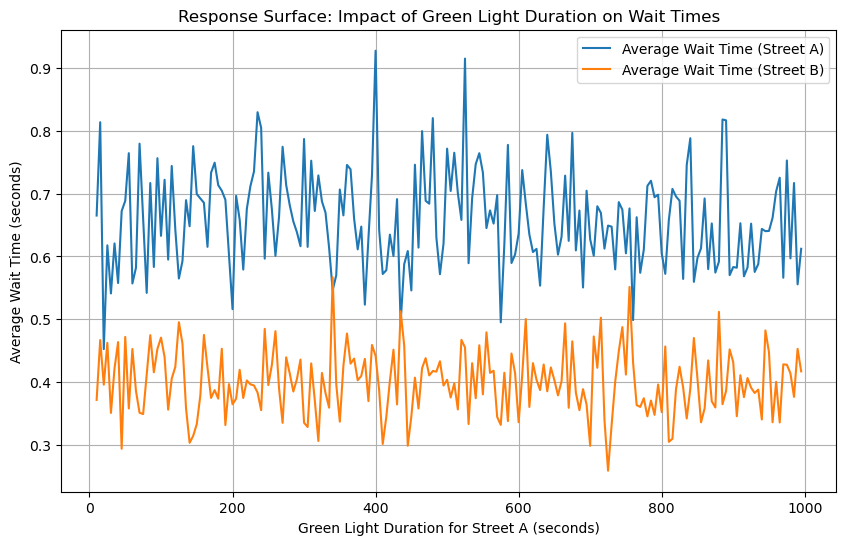

In [15]:
# Constants
VEHICLE_ARRIVAL_RATE_A = 5  # seconds (Street A)
VEHICLE_ARRIVAL_RATE_B = 7  # seconds (Street B)
GREEN_LIGHT_DURATION_A = 30  # seconds
RED_LIGHT_DURATION_A = 20  # seconds (Street A)
GREEN_LIGHT_DURATION_B = RED_LIGHT_DURATION_A  # Green light duration for Street B is red light duration for Street A
RED_LIGHT_DURATION_B = GREEN_LIGHT_DURATION_A  # Red light duration for Street B is green light duration for Street A


# Data collection for response surface
green_light_durations = range(10, 1000, 5)  # Varying GREEN_LIGHT_DURATION_A from 10 to 55 seconds
avg_wait_times_a = []
avg_wait_times_b = []

for green_light_duration_a in green_light_durations:
    wait_times_a = []
    wait_times_b = []
    env = simpy.Environment()
    traffic_light_resource_a = simpy.PriorityResource(env, capacity=CAPACITY)
    traffic_light_resource_b = simpy.PriorityResource(env, capacity=CAPACITY)
    
    simulate_intersection(
        env, traffic_light_resource_a, traffic_light_resource_b, wait_times_a, wait_times_b, 
        VEHICLE_ARRIVAL_RATE_A, VEHICLE_ARRIVAL_RATE_B, 
        green_light_duration_a, RED_LIGHT_DURATION_A
    )
    
    avg_wait_time_a = sum(wait_times_a) / len(wait_times_a) if wait_times_a else 0
    avg_wait_time_b = sum(wait_times_b) / len(wait_times_b) if wait_times_b else 0
    avg_wait_times_a.append(avg_wait_time_a)
    avg_wait_times_b.append(avg_wait_time_b)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(green_light_durations, avg_wait_times_a, label='Average Wait Time (Street A)')
plt.plot(green_light_durations, avg_wait_times_b, label='Average Wait Time (Street B)')
plt.xlabel('Green Light Duration for Street A (seconds)')
plt.ylabel('Average Wait Time (seconds)')
plt.title('Response Surface: Impact of Green Light Duration on Wait Times')
plt.legend()
plt.grid(True)
plt.show()

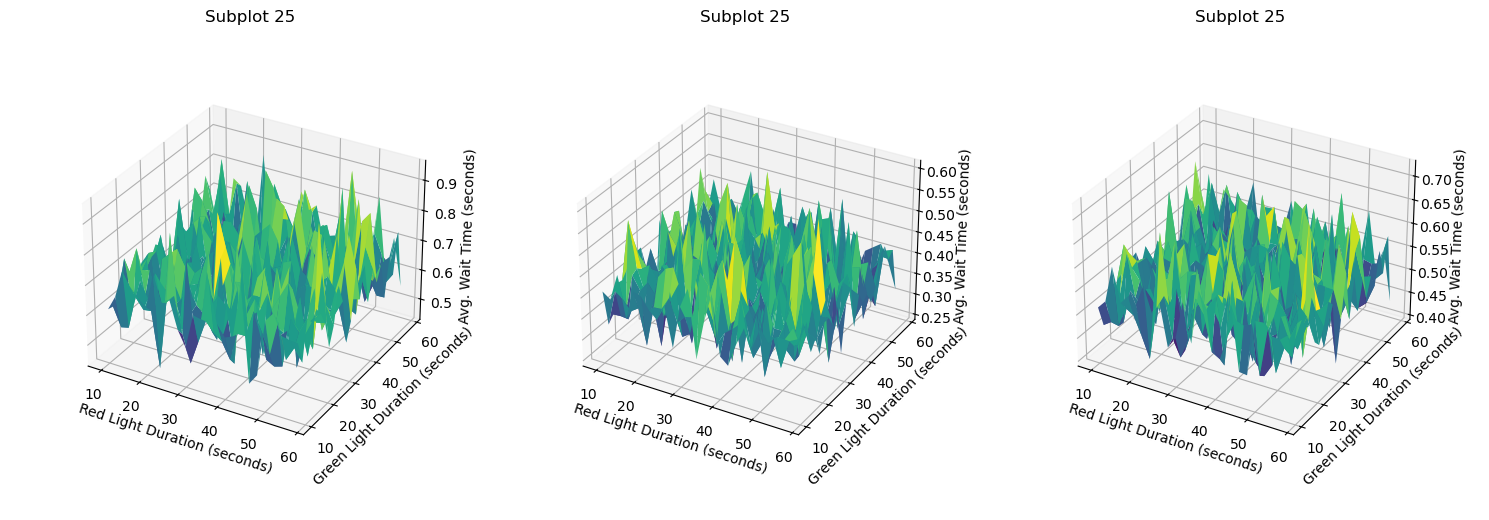

In [5]:
# Constants
VEHICLE_ARRIVAL_RATE_A = 5  # seconds (Street A)
VEHICLE_ARRIVAL_RATE_B = 7  # seconds (Street B)
GREEN_LIGHT_DURATION_A = 30  # seconds
RED_LIGHT_DURATION_A = 20  # seconds (Street A)
GREEN_LIGHT_DURATION_B = RED_LIGHT_DURATION_A  # Green light duration for Street B is red light duration for Street A
RED_LIGHT_DURATION_B = GREEN_LIGHT_DURATION_A  # Red light duration for Street B is green light duration for Street A
TIME_TO_PASS_THROUGH = 2  # seconds
SIM_TIME = 3600  # simulation time in seconds
CAPACITY = 1  # Only one vehicle can pass at a time

# Data collection for response surface
green_light_durations = range(10, 60, 2)  # Varying GREEN_LIGHT_DURATION_A from 10 to 55 seconds
red_light_durations = range(10, 60, 2) # Varying RED_LIGHT_DURATION_A from 10 to 50 seconds

avg_wait_times_a = np.zeros((len(green_light_durations), len(red_light_durations)))
avg_wait_times_b = np.zeros((len(green_light_durations), len(red_light_durations)))
wait_time_grid = np.zeros((len(green_light_durations), len(red_light_durations)))

for i, green_light_duration_a in enumerate(green_light_durations):
    for j, red_light_duration_a in enumerate(red_light_durations):
        wait_times_a = []
        wait_times_b = []
        env = simpy.Environment()

        traffic_light_resource_a = simpy.PriorityResource(env, capacity=CAPACITY)
        traffic_light_resource_b = simpy.PriorityResource(env, capacity=CAPACITY)
        
        simulate_intersection(
            env, traffic_light_resource_a, traffic_light_resource_b, wait_times_a, wait_times_b, 
            VEHICLE_ARRIVAL_RATE_A, VEHICLE_ARRIVAL_RATE_B, 
            green_light_duration_a, red_light_duration_a
        )
        
        avg_wait_time_a = sum(wait_times_a) / len(wait_times_a) if wait_times_a else 0
        avg_wait_time_b = sum(wait_times_b) / len(wait_times_b) if wait_times_b else 0
        aggregated_wait_time = (avg_wait_time_a + avg_wait_time_b) / 2
        
        avg_wait_times_a[i, j] = avg_wait_time_a
        avg_wait_times_b[i, j] = avg_wait_time_b
        wait_time_grid[i, j] = aggregated_wait_time

# Plotting the results
fig, axes = plt.subplots(1, 3, figsize=(15, 12), subplot_kw={'projection': '3d'})
X, Y = np.meshgrid(red_light_durations, green_light_durations)

for Z, title, ax in zip([avg_wait_times_a, avg_wait_times_b, wait_time_grid], ['Direction A', 'Direction B', 'Combined'], axes):

    # for i, ax in enumerate(axes.flatten()):
        surf = ax.plot_surface(X, Y, Z, cmap='viridis')
        ax.set_xlabel('Red Light Duration (seconds)')
        ax.set_ylabel('Green Light Duration (seconds)')
        ax.set_zlabel('Avg. Wait Time (seconds)')
        ax.set_title(f'Subplot {i+1}')
        ax.set_box_aspect(None, zoom=0.8)

# fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
plt.tight_layout()
plt.show()

# # Plotting the results
# plt.figure(figsize=(12, 8))
# X, Y = np.meshgrid(red_light_durations, green_light_durations)
# Z = wait_time_grid

# contour = plt.contourf(X, Y, Z, cmap="viridis", levels=50)
# plt.colorbar(contour)
# plt.xlabel('Red Light Duration (seconds)')
# plt.ylabel('Green Light Duration (seconds)')
# plt.title('Aggregated Wait Time Response Surface')
# plt.show()

(array([10.,  6.,  4.,  4., 12.,  7.,  7.,  6.,  7.,  6.,  6.,  3.,  3.,
         1.,  2.,  2.,  0.,  0.,  1.,  1.,  3.,  1.,  1.,  1.,  1.,  1.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0.05048139,  0.58619615,  1.12191092,  1.65762568,  2.19334044,
         2.7290552 ,  3.26476996,  3.80048472,  4.33619948,  4.87191424,
         5.407629  ,  5.94334377,  6.47905853,  7.01477329,  7.55048805,
         8.08620281,  8.62191757,  9.15763233,  9.69334709, 10.22906185,
        10.76477662, 11.30049138, 11.83620614, 12.3719209 , 12.90763566,
        13.44335042, 13.97906518, 14.51477994, 15.05049471, 15.58620947,
        16.12192423, 16.65763899, 17.19335375, 17.72906851, 18.26478327,
        18.80049803, 19.33621279, 19.87192756, 20.40764232, 20.94335708,
        21.47907184, 22.0147866 , 22.55050136, 23.08621612, 23.62193088,
        24.15764564, 24.69336041, 25.22907517, 25.76478993,

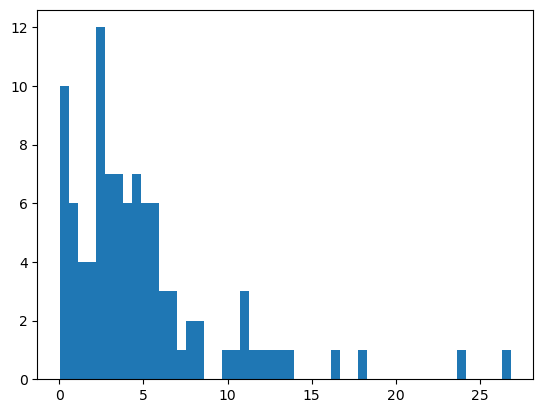

In [6]:
times = []

for _ in range(100):
    times.append(random.expovariate(1 / VEHICLE_ARRIVAL_RATE_A))

plt.hist(times, bins=50)

In [7]:
wait_time_grid.shape

(25, 25)

In [8]:
len(avg_wait_times_a)

25

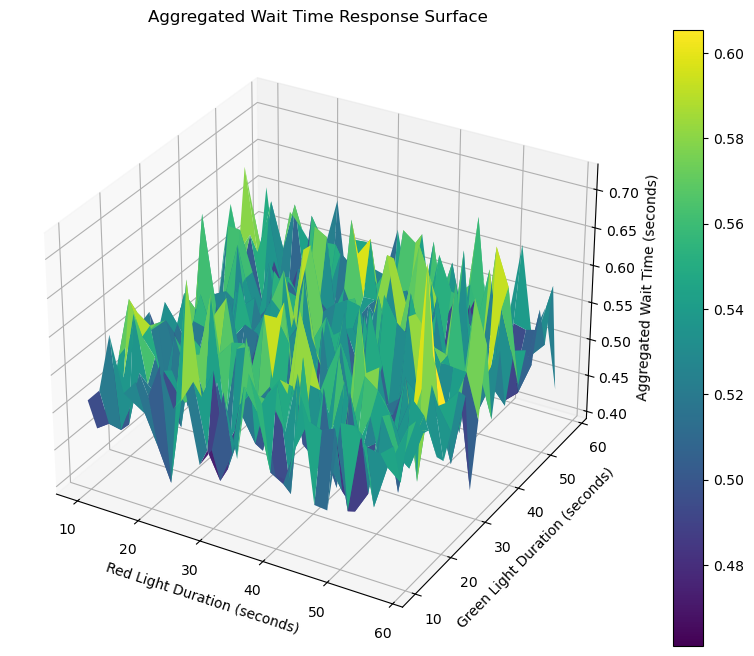

In [9]:
# Create 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis')

ax.set_xlabel('Red Light Duration (seconds)')
ax.set_ylabel('Green Light Duration (seconds)')
ax.set_zlabel('Aggregated Wait Time (seconds)')
ax.set_title('Aggregated Wait Time Response Surface')

fig.colorbar(surf)
plt.show()

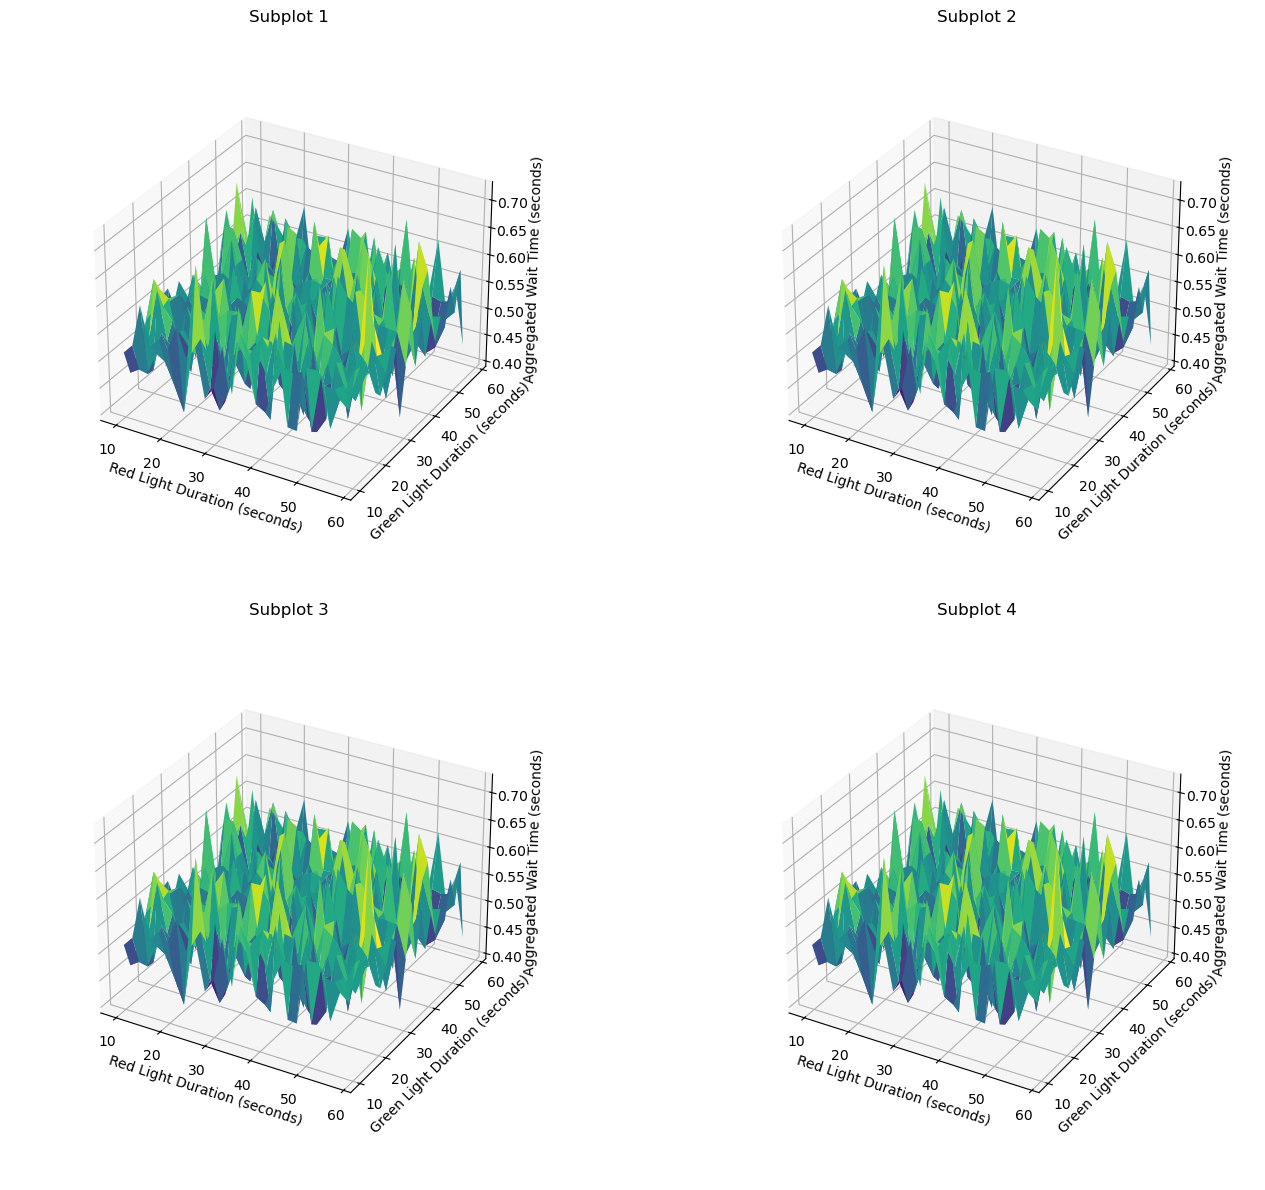

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12), subplot_kw={'projection': '3d'})

for i, ax in enumerate(axes.flatten()):
    surf = ax.plot_surface(X, Y, Z, cmap='viridis')
    ax.set_xlabel('Red Light Duration (seconds)')
    ax.set_ylabel('Green Light Duration (seconds)')
    ax.set_zlabel('Aggregated Wait Time (seconds)')
    ax.set_title(f'Subplot {i+1}')
    ax.set_box_aspect(None, zoom=0.8)
    # fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

plt.tight_layout()
plt.show()

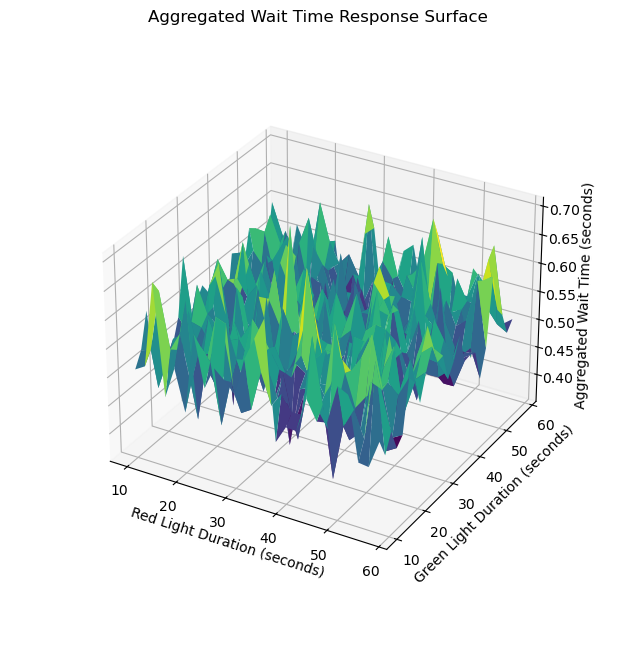

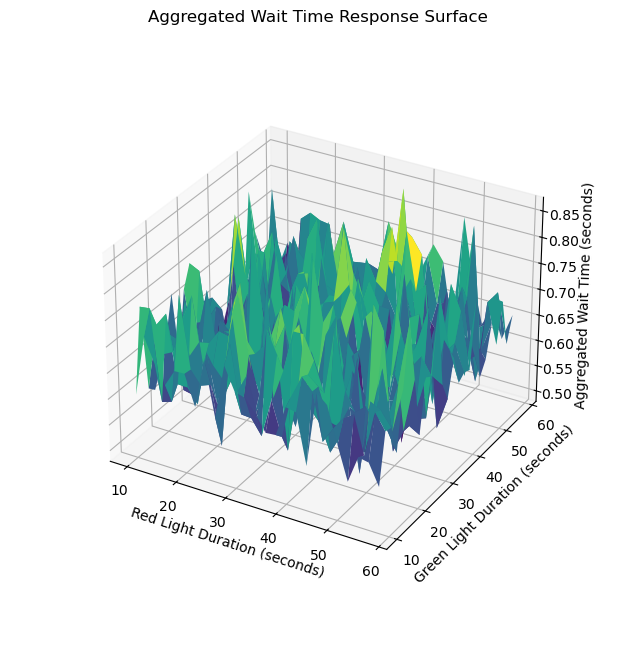

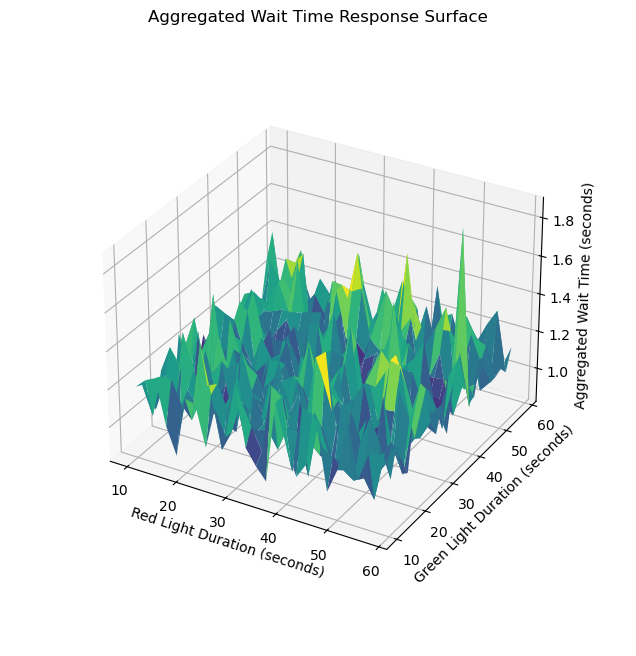

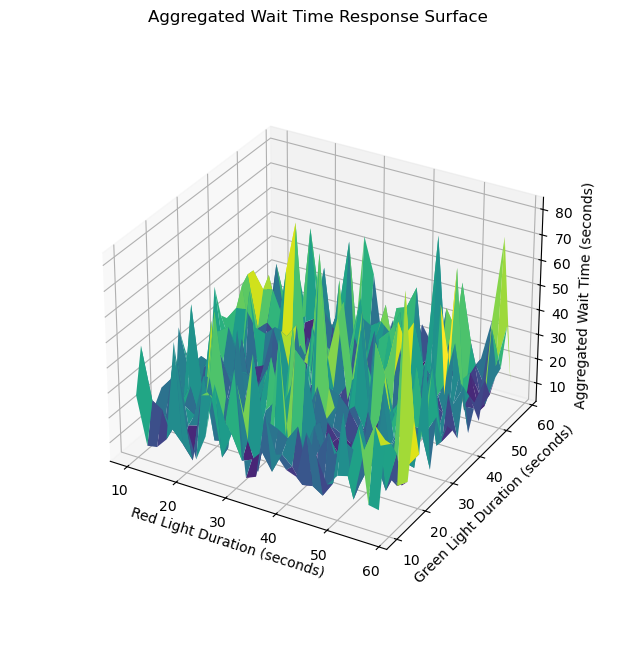

In [11]:
arrival_rates = [[5, 7], [4, 8], [3, 9], [2, 10]]

for arrival_rate_a, arrival_rate_b in arrival_rates:
    for i, green_light_duration_a in enumerate(green_light_durations):
        for j, red_light_duration_a in enumerate(red_light_durations):
            wait_times_a = []
            wait_times_b = []
            env = simpy.Environment()

            traffic_light_resource_a = simpy.PriorityResource(env, capacity=CAPACITY)
            traffic_light_resource_b = simpy.PriorityResource(env, capacity=CAPACITY)
            
            simulate_intersection(
                env, traffic_light_resource_a, traffic_light_resource_b, wait_times_a, wait_times_b, 
                arrival_rate_a, arrival_rate_b, 
                green_light_duration_a, RED_LIGHT_DURATION_A
            )
            
            avg_wait_time_a = sum(wait_times_a) / len(wait_times_a) if wait_times_a else 0
            avg_wait_time_b = sum(wait_times_b) / len(wait_times_b) if wait_times_b else 0
            aggregated_wait_time = (avg_wait_time_a + avg_wait_time_b) / 2
            
            wait_time_grid[i, j] = aggregated_wait_time

    # Create 3D plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap='viridis')

    ax.set_xlabel('Red Light Duration (seconds)')
    ax.set_ylabel('Green Light Duration (seconds)')
    ax.set_zlabel('Aggregated Wait Time (seconds)')
    ax.set_title('Aggregated Wait Time Response Surface')
    ax.set_box_aspect(None, zoom=0.8)
    
    plt.show()